# Today's at the moment stock data analysis

This notebook looks at today's at the moment stock data, to find the top five largest stocks by
3 month average volume for a particular time. Use yfinance to get information about each of those stocks, and
use data visualization to see how each of those stocks is performing for the past year. The goal
is to check to see when the stock had it's highest and lowest price. Looking at one of those five
stocks for a period of one year, this notebook shows the closing and opening price from the last
time the data was scrapped, and goes back daily for one year.

**Dates and times are subject to the stock trading calendar.**


Using  yfinance, which is built in on yahoo finance API for analysis, and for visualization plotly is used to create interactive graphs of the data.

In [1]:
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.express as px


# to print current time and a day of the week and formatted
date = pd.Timestamp(datetime.datetime.today())
today = f"{date.day_name()} {date.strftime('%m-%d-%y %H:%M:%S')} "
today

'Thursday 03-30-23 23:06:16 '

A function is created to change 'M', 'B', 'T' to its corresponding 10^n and changing the data type

In [2]:
def convert_scale(x):
    if type(x) == float or type(x) == int:
        return x
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000.0
    elif 'B' in x:
        if len(x) > 1:
            return float(x.replace('B', '')) * 1000000000
        return 1000000.0
    elif 'T' in x:
        return float(x.replace('T', '')) * 1000000000000
    else:
        return float(x)

## Feature 1: Loading Data
As per the requirement, two datasets are to be loaded in. Pandas .read_html function is used to read in HTML tables into a list of Dataframe objects. Tables are read in from https://finance.yahoo.com/. From there, most-active, gainers and losers tables are webscrapped.

The default filters used on the links.
1. most-active
    Region: United States, Market Cap (Intraday): Mid Cap and Large Cap and Mega Cap, Volume:greater than 5000000
2. gainers
    % Change in Price (Intraday):greater than 3, Region: United States, Market Cap (Intraday): Mid Cap and Large Cap and Mega Cap, Volume:greater than 15000
3. losers
    % Change in Price (Intraday):less than -2.5, Region: United States, Market Cap (Intraday): Mid Cap and Large Cap and Mega Cap, Volume:greater than 20000

Pandas module was imported.
Using the read_html() method and passing the URL, results in get all the HTML tables from the website. The read_html() method returns a list.
Now that there is a list holding the tables, in order to access the first element in the list, pass the data as an argument to the Pandas Dataframe() method to create new dataset. 

In [3]:
# reading in from a website and getting only the 1st page
most_active = pd.read_html('https://finance.yahoo.com/most-active')[0]
print(most_active.shape) #shows the shape of table
most_active.head() #print first 5 rows


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,TSLA,"Tesla, Inc.",195.28,1.40,+0.72%,109.497M,174.793M,633.203B,54.09,NaN
1,INTC,Intel Corporation,32.09,0.57,+1.81%,70.078M,46.802M,142.864B,17.83,NaN
2,BAC,Bank of America Corporation,28.30,-0.37,-1.29%,62.874M,56.23M,230.807B,9.04,NaN
3,NIO,NIO Inc.,10.46,0.63,+6.41%,65.263M,45.574M,17.474B,NaN,NaN
4,OSH,"Oak Street Health, Inc.",38.70,1.69,+4.57%,60.932M,6.37M,9.642B,NaN,NaN


In [4]:
# reading in 2nd table
gainers = pd.read_html('https://finance.yahoo.com/gainers')[0]
print(gainers.shape)
gainers.head()


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,NAAS,NaaS Technology Inc.,9.24,1.47,+18.92%,3.983M,343945,2.309B,NaN,NaN
1,HNNMY,H & M Hennes & Mauritz AB (publ),2.71,0.41,+17.83%,121644,57973,22.755B,24.64,NaN
2,CXM,"Sprinklr, Inc.",12.79,1.91,+17.56%,5.508M,968257,3.414B,NaN,NaN
3,FLNC,"Fluence Energy, Inc.",18.64,2.39,+14.71%,3.131M,1.217M,3.342B,NaN,NaN
4,HSAI,Hesai Group,16.98,1.92,+12.75%,264373,614465,2.132B,NaN,NaN


In [5]:
# reading in 3rd table
losers = pd.read_html('https://finance.yahoo.com/losers')[0]
print(losers.shape)
losers.head()


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,AGL,"agilon health, inc.",23.37,-3.42,-12.77%,10.6M,2.527M,9.655B,NaN,NaN
1,TRMD,TORM plc,28.53,-4.16,-12.74%,2.479M,341847,2.755B,4.81,NaN
2,GRAB,Grab Holdings Limited,2.85,-0.17,-5.63%,20.941M,16.868M,10.944B,NaN,NaN
3,NEOG,Neogen Corporation,17.45,-1.04,-5.62%,3.912M,2.07M,3.819B,NaN,NaN
4,DNLI,Denali Therapeutics Inc.,21.91,-1.18,-5.11%,863293,677639,2.995B,NaN,NaN


## Feature 2: Clean and operate on the data while combining them.


The concat() function was used to combine multiple datasets to create a new one. Concat
function stacks the dataset on top of each other. Then analysis can be performed on the new
combined dataset. To have a continuous index the 'ignore_index=True' parameter was used. A
custom function that converts 'M', 'B', and 'T' into corresponding 10^n values was used. The
fillna() function was used to replace Nan values with 0. The drop() function was used to delete a
column.

In [6]:
# joining 3 datasets into 1 dataframe.
stocks_df = pd.concat([most_active, gainers, losers],  ignore_index=True)
print(stocks_df.shape) # shows shape of new dataframe
print('Datatype before the change \n ')
stocks_df.info() 
stocks_df.head() # prints top 5 rows



(75, 10)
Datatype before the change 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Symbol             75 non-null     object 
 1   Name               75 non-null     object 
 2   Price (Intraday)   75 non-null     float64
 3   Change             75 non-null     float64
 4   % Change           75 non-null     object 
 5   Volume             75 non-null     object 
 6   Avg Vol (3 month)  75 non-null     object 
 7   Market Cap         75 non-null     object 
 8   PE Ratio (TTM)     41 non-null     float64
 9   52 Week Range      0 non-null      float64
dtypes: float64(4), object(6)
memory usage: 6.0+ KB


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,TSLA,"Tesla, Inc.",195.28,1.40,+0.72%,109.497M,174.793M,633.203B,54.09,NaN
1,INTC,Intel Corporation,32.09,0.57,+1.81%,70.078M,46.802M,142.864B,17.83,NaN
2,BAC,Bank of America Corporation,28.30,-0.37,-1.29%,62.874M,56.23M,230.807B,9.04,NaN
3,NIO,NIO Inc.,10.46,0.63,+6.41%,65.263M,45.574M,17.474B,NaN,NaN
4,OSH,"Oak Street Health, Inc.",38.70,1.69,+4.57%,60.932M,6.37M,9.642B,NaN,NaN


The dropna() function was used to remove the '52 Week Range' column, which consists of NaN
values. Replaced NaN values with 0's using the fillna() function in the 'PE Ratio (TTM)' column.
The apply(convert_scale) function was used to convert the scale, change the datatypes from
object to float64 for 'Volume', 'Avg Vol (3 month)', 'Market Cap' columns. Lastly, the % was
changed to ' ' with a regex=True param. The dataype for '% Change' column was changed using
pandas to_numeric function.

In [7]:
# fill in 0 for NaN values 
stocks_df[['PE Ratio (TTM)', 'Avg Vol (3 month)']] = stocks_df[['PE Ratio (TTM)', 'Avg Vol (3 month)']].fillna(0) # fill in 0 where NaN
stocks_df.dropna(axis=1, thresh=9, inplace=True) # drop a column

#using .apply function to convert the scale n datatypes
stocks_df['Volume'] = stocks_df['Volume'].apply(convert_scale) 
stocks_df['Avg Vol (3 month)'] = stocks_df['Avg Vol (3 month)'].apply(convert_scale)
stocks_df['Market Cap'] = stocks_df['Market Cap'].apply(convert_scale)

# replacing %:'' and changing the dtype of column
stocks_df['% Change'] = pd.to_numeric(stocks_df['% Change'].replace({'%' : ''}, regex=True))
stocks_df.sort_values('Symbol', inplace=True) # sorting the rows in alphabetical order.

print(stocks_df.shape)
print('Datatypes after the change: \n') 
stocks_df.info() # shows all the columns, non null count and dtypes
stocks_df.head()

(75, 9)
Datatypes after the change: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 13 to 70
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Symbol             75 non-null     object 
 1   Name               75 non-null     object 
 2   Price (Intraday)   75 non-null     float64
 3   Change             75 non-null     float64
 4   % Change           75 non-null     float64
 5   Volume             75 non-null     float64
 6   Avg Vol (3 month)  75 non-null     float64
 7   Market Cap         75 non-null     float64
 8   PE Ratio (TTM)     75 non-null     float64
dtypes: float64(7), object(2)
memory usage: 5.9+ KB


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
13,AAPL,Apple Inc.,162.36,1.59,0.99,44936000.0,68887000.0,2.620000e+12,28.14
47,ADDYY,adidas AG,84.57,5.09,6.40,54958.0,131660.0,3.132700e+10,130.11
50,AGL,"agilon health, inc.",23.37,-3.42,-12.77,10600000.0,2527000.0,9.655000e+09,0.00
48,AI,"C3.ai, Inc.",27.63,1.65,6.35,16566000.0,19188000.0,3.302000e+09,0.00
6,AMD,"Advanced Micro Devices, Inc.",97.88,1.79,1.86,57088000.0,62743000.0,1.602750e+11,116.52


The pandas concat() function stacks data sets on top of each other. Collecting most_active,
gainers and losers stocks, most_active stocks could be a gainer or a loser for any given day.
Thus, the duplicated() function was used to check for any duplicate rows then drop_duplicates deletes the duplicated row/s.

In [8]:
# find if there are any duplicated rows referencing column Symbol

duplicate = stocks_df[stocks_df.duplicated('Symbol')]
duplicate

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
68,FRC,First Republic Bank,13.69,-0.57,-4.00,44522000.0,29939000.0,2.655000e+09,1.73
15,JD,"JD.com, Inc.",44.40,3.22,7.82,32047000.0,9508000.0,6.961900e+10,47.74
46,NIO,NIO Inc.,10.46,0.63,6.41,65263000.0,45574000.0,1.747400e+10,0.00
10,SCHW,The Charles Schwab Corporation,52.47,-2.74,-4.96,45064000.0,21575000.0,9.838700e+10,14.99


In [9]:
# if there is any duplicates drop_duplicates function will delete the rows, 
# keep='last' param keeps the last occurence and drops anything else. 
# inplace= True would replace the original df 
stocks_df.drop_duplicates(subset=['Symbol'], keep='last', inplace=True, ignore_index=True) 
print(stocks_df.shape) # prints updated shape of df

pd.set_option('display.max_rows', None) # displays all the rows
stocks_df # dispalys all the rows in a df


(71, 9)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
0,AAPL,Apple Inc.,162.3600,1.5900,0.99,44936000.0,68887000.0,2.620000e+12,28.14
1,ADDYY,adidas AG,84.5700,5.0900,6.40,54958.0,131660.0,3.132700e+10,130.11
2,AGL,"agilon health, inc.",23.3700,-3.4200,-12.77,10600000.0,2527000.0,9.655000e+09,0.00
3,AI,"C3.ai, Inc.",27.6300,1.6500,6.35,16566000.0,19188000.0,3.302000e+09,0.00
4,AMD,"Advanced Micro Devices, Inc.",97.8800,1.7900,1.86,57088000.0,62743000.0,1.602750e+11,116.52
5,AMZN,"Amazon.com, Inc.",102.0000,1.7500,1.75,50616000.0,68526000.0,1.078000e+12,0.00
6,ATAT,Atour Lifestyle Holdings Limited,23.6000,-1.0300,-4.18,225858.0,228018.0,3.081000e+09,157.33
7,AUY,Yamana Gold Inc.,5.8900,-0.0200,-0.34,36889000.0,13413000.0,5.660000e+09,21.81
8,BABA,Alibaba Group Holding Limited,103.3800,3.4600,3.46,56945000.0,24248000.0,2.674960e+11,49.46
9,BAC,Bank of America Corporation,28.3000,-0.3700,-1.29,62874000.0,56230000.0,2.308070e+11,9.04


## Feature 2.1 Data Analysis:



Important Note: Each time the code is run, new stocks could be present because the code webscrapes from the website using .read_html. During trading hours, most active, gainers and losers change over time. As a result, some of the queries might not be displaying any results. 

       Price (Intraday)     Change   % Change        Volume  \
count         71.000000  71.000000  71.000000  7.100000e+01   
mean          38.946821   0.250807   1.954366  1.737713e+07   
std           57.576146   2.028146   6.785592  2.358511e+07   
min            0.007800  -4.160000 -12.770000  1.797800e+04   
25%            6.170000  -0.710000  -4.050000  4.763490e+05   
50%           17.450000   0.110000   1.480000  2.844000e+06   
75%           38.155000   1.140000   6.580000  2.883600e+07   
max          284.050000   9.830000  18.920000  1.094970e+08   

       Avg Vol (3 month)    Market Cap  PE Ratio (TTM)  
count       7.100000e+01  7.100000e+01       71.000000  
mean        1.656212e+07  1.648128e+11       17.978732  
std         2.777982e+07  4.672561e+11       32.968575  
min         9.405000e+03  2.025000e+09        0.000000  
25%         3.796200e+05  3.304000e+09        0.000000  
50%         1.780000e+06  5.369000e+09        4.810000  
75%         2.766000e+07  3.91230

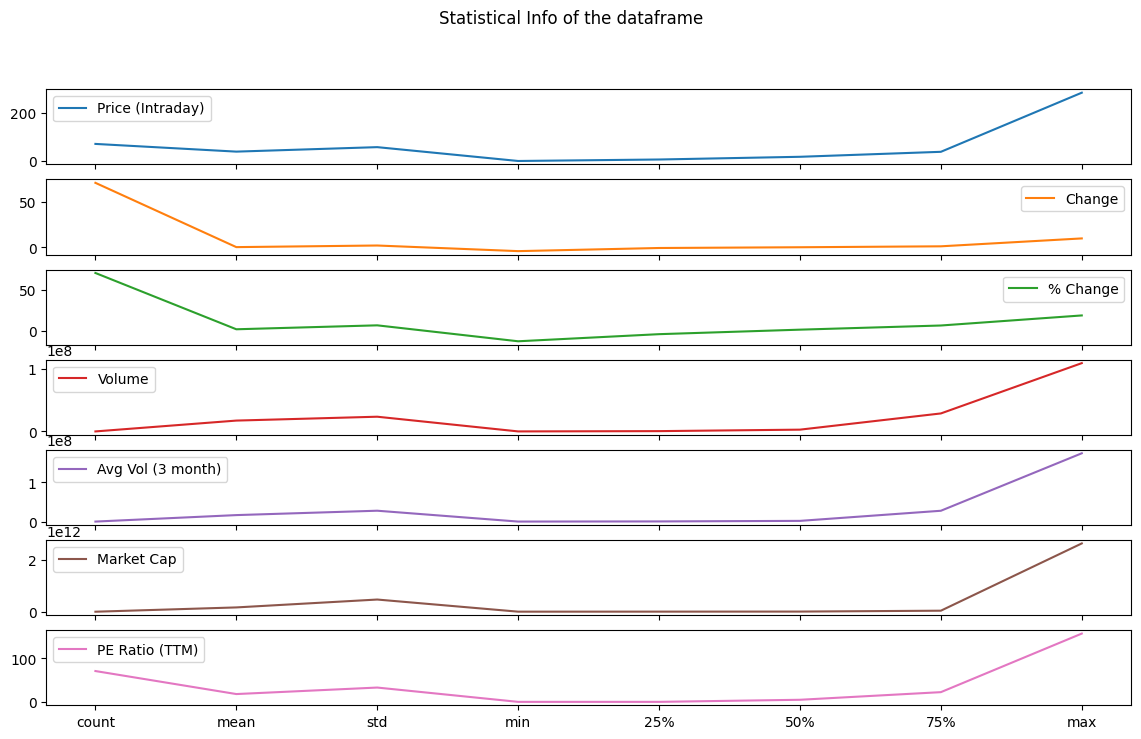

In [27]:
# describe method displays the basic statistical values
stocks_df.describe().plot(subplots=True, figsize=(14,8), title='Statistical Info of the dataframe')
print(stocks_df.describe())

1. Find all rows that have 'Ban' in its name column?

At the time of this data analysis, bank stocks are the most active and volatile. Some banks use
'Banc, while others use 'Bank', therefore 'Ban' was used as the search term.

In [11]:
# find all rows that have 'Ban' in its name column?
stocks_df.loc[stocks_df.Name.str.contains('(?i)Ban', regex=True)]

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
9,BAC,Bank of America Corporation,28.30,-0.37,-1.29,62874000.0,56230000.0,2.308070e+11,9.04
10,BBD,Banco Bradesco S.A.,2.63,0.11,4.37,29356000.0,36759000.0,2.798900e+10,7.31
12,BOH,Bank of Hawaii Corporation,50.82,-1.91,-3.62,576917.0,453891.0,2.025000e+09,9.27
25,FRC,First Republic Bank,13.69,-0.57,-4.00,44522000.0,29939000.0,2.655000e+09,1.73
34,ITUB,Itaú Unibanco Holding S.A.,4.80,0.16,3.45,28316000.0,33278000.0,4.691900e+10,8.28
66,UBSI,"United Bankshares, Inc.",35.03,-1.53,-4.18,694045.0,691716.0,4.926000e+09,12.51
67,VLY,Valley National Bancorp,9.30,-0.35,-3.63,4929000.0,4080000.0,4.900000e+09,8.16


2. Get all the rows where volume is at least 20 million and the daily change is at least -5?

In [12]:
volume_change = stocks_df.query('Volume >= 20000000 and Change <= -5')[['Name', 'Change', 'Volume']]
volume_change

,Name,Change,Volume


3. Find stocks that dropped below 25% and print its symbol, name and % Change ?

In [13]:
stocks_below_25 = stocks_df.query('`% Change` < -25')[['Symbol', 'Name', '% Change']]
stocks_below_25

,Symbol,Name,% Change


4. Any stocks that performed over 10% today and how many times they transacted today?

In [14]:
stocks_above_20 = stocks_df.query('`% Change` > 10')[['Symbol', 'Name', '% Change', 'Volume']]
stocks_above_20

,Symbol,Name,% Change,Volume
20,CXM,"Sprinklr, Inc.",17.56,5508000.0
24,FLNC,"Fluence Energy, Inc.",14.71,3131000.0
30,HELFY,HelloFresh SE,11.93,32914.0
31,HNNMY,H & M Hennes & Mauritz AB (publ),17.83,121644.0
32,HSAI,Hesai Group,12.75,264373.0
43,NAAS,NaaS Technology Inc.,18.92,3983000.0
50,OCDDY,Ocado Group plc,10.10,30100.0
52,PBMRF,PT Bumi Resources Tbk,11.43,1069000.0


5. Find a company that starts with "S", has a PE Ratio greater than or equal to 5 and the difference is less than or equal to 5?

In [15]:

Symbol_s = stocks_df.loc[(stocks_df['PE Ratio (TTM)']>=5) & (stocks_df['Change']<= 5) & (stocks_df['Symbol'].str.startswith('S')),['Symbol', 'Name', 'Change', 'PE Ratio (TTM)']]
Symbol_s

,Symbol,Name,Change,PE Ratio (TTM)
62,SCHW,The Charles Schwab Corporation,-2.74,14.99


6. Is there any company that has Market Cap of 100 Billion or more? print only name and market cap.

In order to filter a DataFrame column that has spaces with the query method, we wrap the column using backticks. While this may not look great, it does allow us to use any column in the method.


In [29]:
large_market_cap = stocks_df.query("`Market Cap` > 100000000000")[['Name', 'Market Cap']]
#print(large_market_cap)

fig = px.bar(large_market_cap, x='Name', y='Market Cap', title='Companies valued at $100 Billion or more')
fig.show()


7. List of companies to invest in that are less than $10 per share?

In [17]:
com_below_10 = stocks_df[stocks_df['Price (Intraday)'] <= 10]
print(com_below_10.shape)
com_below_10

(25, 9)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
7,AUY,Yamana Gold Inc.,5.8900,-0.0200,-0.34,36889000.0,13413000.0,5.660000e+09,21.81
10,BBD,Banco Bradesco S.A.,2.6300,0.1100,4.37,29356000.0,36759000.0,2.798900e+10,7.31
13,BPIRY,Piraeus Financial Holdings S.A.,2.1800,0.1650,8.19,27451.0,49940.0,2.725000e+09,2.63
15,CD,Chindata Group Holdings Limited,7.0900,0.4800,7.26,1340000.0,1226000.0,2.587000e+09,26.26
17,CGSHY,Country Garden Services Holdings Company Limited,1.7900,0.1400,8.48,20032.0,12679.0,6.057000e+09,8.95
18,CIG-C,Companhia Energética de Minas Gerais,3.3900,0.2200,6.94,40107.0,39803.0,7.460000e+09,10.94
19,CURLF,"Curaleaf Holdings, Inc.",2.8500,-0.1100,-3.72,205770.0,686395.0,2.049000e+09,0.00
26,GOL,Gol Linhas Aéreas Inteligentes S.A.,2.6300,0.1700,6.91,1477000.0,1672000.0,4.207000e+09,0.00
29,GRAB,Grab Holdings Limited,2.8500,-0.1700,-5.63,20941000.0,16868000.0,1.094400e+10,0.00
30,HELFY,HelloFresh SE,5.6300,0.6000,11.93,32914.0,26585.0,3.912000e+09,33.12


## Feature 3: Visualize/Present your data.

In order to find the top five companies by 3 month Average Volume for a particular day, and see how those
stocks are performing for the past year, yfinance library was used. yfinance is a package
designed to download historical stock data from Yahoo Finance. Data is visualized using the
plotly library.

In [18]:
top_5_company = stocks_df.nlargest(5,['Avg Vol (3 month)'])
top_5_company

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
65,TSLA,"Tesla, Inc.",195.28,1.40,0.72,109497000.0,174793000.0,6.332030e+11,54.09
22,F,Ford Motor Company,12.29,0.24,1.99,55818000.0,69225000.0,5.089100e+10,0.00
0,AAPL,Apple Inc.,162.36,1.59,0.99,44936000.0,68887000.0,2.620000e+12,28.14
5,AMZN,"Amazon.com, Inc.",102.00,1.75,1.75,50616000.0,68526000.0,1.078000e+12,0.00
4,AMD,"Advanced Micro Devices, Inc.",97.88,1.79,1.86,57088000.0,62743000.0,1.602750e+11,116.52


In [19]:
# taking a column and chaging it to a list
top_5_volume = (top_5_company.Symbol).to_list()
top_5_volume

['TSLA', 'F', 'AAPL', 'AMZN', 'AMD']

With the yfinance's download method, multiple ticker symbols can be downloaded at the same
time. Each time the list is generated it is passed as the file to run. Since this project is not rigid
and the data changes according to stock market performance. Data is downloaded for a one
year period, with a period of one day intervals, as the stock market is open, timezones are
ignored. To remove the 'Adjust Close Price' column, use auto_adjust=True. Dividends and splits
of stock can be downloaded by setting actions ='inline'. Which this project does not include.

In [20]:
# downloads the stock data for the list of tickers for 1y period
ticker = yf.download(top_5_volume, period='1y',interval='1d', ignore_tz=True, progress=False, auto_adjust=True )
ticker.info() # displays information about the columns
pd.set_option('display.max_columns', None) # displays all the columns with a scroll bar
ticker.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-03-31 to 2023-03-30
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   251 non-null    float64
 1   (Close, AMD)    251 non-null    float64
 2   (Close, AMZN)   251 non-null    float64
 3   (Close, F)      251 non-null    float64
 4   (Close, TSLA)   251 non-null    float64
 5   (High, AAPL)    251 non-null    float64
 6   (High, AMD)     251 non-null    float64
 7   (High, AMZN)    251 non-null    float64
 8   (High, F)       251 non-null    float64
 9   (High, TSLA)    251 non-null    float64
 10  (Low, AAPL)     251 non-null    float64
 11  (Low, AMD)      251 non-null    float64
 12  (Low, AMZN)     251 non-null    float64
 13  (Low, F)        251 non-null    float64
 14  (Low, TSLA)     251 non-null    float64
 15  (Open, AAPL)    251 non-null    float64
 16  (Open, AMD)     251 non-null    float64
 17  (Open, AMZN)    

Close                                                 \
                  AAPL         AMD        AMZN          F        TSLA   
Date                                                                    
2022-03-31  173.558640  109.339996  162.997498  15.484148  359.200012   
2022-04-01  173.260422  108.190002  163.559998  15.246071  361.529999   
2022-04-04  177.365570  110.529999  168.346497  15.255228  381.816681   
2022-04-05  174.005920  106.820000  164.054993  14.486057  363.753326   
2022-04-06  170.795364  103.669998  158.755997  14.092315  348.586670   

                  High                                                 \
                  AAPL         AMD        AMZN          F        TSLA   
Date                                                                    
2022-03-31  176.958045  116.379997  166.494995  15.887048  367.713318   
2022-04-01  173.826997  111.419998  165.826996  15.703911  364.916656   
2022-04-04  177.415272  110.940002  168.394501  15.319325  383.303345   
2022-04-05  177.226417  110.480003  168.110504  15.218602  384.290009   
2022-04-06  172.584529  105.739998  162.199997  14.467743  359.666656   

                   Low                                                 \
                  AAPL         AMD        AMZN          F        TSLA   
Date                                                                    
2022-03-31  173.349897  109.019997  162.953506  15.108719  358.880005   
2022-04-01  170.904697  106.099998  162.319504  14.962211  355.546661   
2022-04-04  173.389655  107.029999  163.205505  14.980525  357.510010   
2022-04-05  173.369775  106.050003  163.266006  14.476901  362.433319   
2022-04-06  169.105604  101.709999  157.254501  13.900022  342.566681   

                  Open                                                 \
                  AAPL         AMD        AMZN          F        TSLA   
Date                                                                    
2022-03-31  176.769187  116.309998  166.445007  15.749696  364.856659   
2022-04-01  172.982109  110.480003  164.149506  15.575716  360.383331   
2022-04-04  173.518877  109.970001  164.125000  15.255228  363.126678   
2022-04-05  176.431231  109.690002  167.741501  15.072092  378.766663   
2022-04-06  171.322172  104.449997  161.650497  14.284608  357.823334   

               Volume                                            
                 AAPL        AMD      AMZN          F      TSLA  
Date                                                             
2022-03-31  103049300  147004800  59966000   52529400  48992700  
2022-04-01   78751300  111867100  57090000   64695700  54263100  
2022-04-04   76468400   90123900  49882000   51146500  82035900  
2022-04-05   73401800   79532000  53728000   91708000  80075100  
2022-04-06   89058800  105256600  79056000  102881600  89348400

## Plotting Data


##### Plotly is an open-source, interactive data visualization library for Python that is built Plotly JavaScript Library (plotly.js) as sometimes referred to as "plotly.py". Plotly supports over 40 unique chart types covering a wide range of statistical, financial, geographic, scientific, and 3-D use-cases to create interactive web-based visualizations that can be displayed in Jupyter notebook, saved to standalone HTML files, or served as part of pure Python-built web applications using Dash.

In order to get the data for closing price, Only the Close column was selected for all five tickers. The highest and lowest Closing price is shown using .max and .min method. Then, the 1 year data is plotted on a line graph. Since it is interactive data, as the user hovers over the graph, it shows the ticker symbol, trading date and the price on that day.

In [30]:
close = ticker.Close
#print(close)
max = close.max()
print(f'The highest closing price for these companies are: \n{max}\n')
min = close.min()
print(f'The lowest closing price for these companies are: \n{min}')

fig = px.line(close, title=f"Closing Price for stocks with largest 3mth volume on {today} for the past year",) 
fig.show()

The highest closing price for these companies are: 
AAPL    177.365570
AMD     110.529999
AMZN    168.346497
F        15.484148
TSLA    381.816681
dtype: float64

The lowest closing price for these companies are: 
AAPL    124.829399
AMD      55.939999
AMZN     81.820000
F        10.194802
TSLA    108.099998
dtype: float64


In order to get the data for opening price, only the Open column was selected for all five tickers. The highest and lowest Opening price is shown using .max and .min method. Then, the 1 year data is plotted on a filled area graph. It is an interactive data, as the user hovers over the graph, it shows the ticker symbol, trading date and the price on that day.

In [31]:
open = ticker.Open
max = open.max()
print(f'The highest opening price for these companies are: \n{max}\n')
min = open.min()
print(f'The lowest opening price for these companies are: \n{min}')
px.area(open, title=f"Opening price for stocks with largest 3 mth volume on {today} for the past year")

The highest opening price for these companies are: 
AAPL    176.769187
AMD     116.309998
AMZN    167.741501
F        15.749696
TSLA    378.766663
dtype: float64

The lowest opening price for these companies are: 
AAPL    125.817904
AMD      55.520000
AMZN     82.800003
F        10.185583
TSLA    103.000000
dtype: float64


In order to get the data for high price, Only the High column was selected for all five tickers. The highest and lowest High price is shown using .max and .min method. Then, the 1 year data is plotted on a plotly bar graph. Since it is an interactive data, as the user hovers over the graph, it shows the ticker symbol, trading date and the price on that day.

In [23]:
high = ticker.High
max = high.max()
print(f'The highest high price for these companies are: \n{max}\n')
min = high.min()
print(f'The lowest high price for these companies are: \n{min}') 

figure = px.bar(high, title=f" High's for stocks with largest 3mth volume on {today} for the past year")
figure.show()

The highest high price for these companies are: 
AAPL    177.415272
AMD     116.379997
AMZN    168.394501
F        15.887048
TSLA    384.290009
dtype: float64

The lowest high price for these companies are: 
AAPL    127.575207
AMD      58.320000
AMZN     83.480003
F        10.333067
TSLA    111.750000
dtype: float64


In order to get the data for low price, Only the Low column was selected for all five tickers. The highest and lowest Low price is shown using .max and .min method. Then, the 1 year data is plotted on a scatter plot. Since it is interactive data, as the user hovers over the graph, it shows the ticker symbol, trading date and the price on that day.

In [24]:
low = ticker.Low
max = low.max()
print(f'The highest low price for these companies are: \n{max}\n')
min = low.min()
print(f'The lowest low price for these companies are: \n{min}')
figure = px.scatter(ticker.Low, title=f"Low's for stocks with largest 3mth volume on {today} for the past year")
figure.show()

The highest low price for these companies are: 
AAPL    173.389655
AMD     109.019997
AMZN    163.266006
F        15.137500
TSLA    362.433319
dtype: float64

The lowest low price for these companies are: 
AAPL    123.980696
AMD      54.570000
AMZN     81.430000
F         9.780003
TSLA    101.809998
dtype: float64


In order to get the data for volume, Only the Volume column was selected for all five tickers. .describe() method is shown to show basic statistics. Then, the 1 year data is plotted on a box plot. As the user hovers over the graph for each company, the graph will display seven different statistics, such as the maximum, median, and minimum trading volume, for a period of one year.

In [25]:
volume = ticker.Volume
print(volume.describe())

fig = px.box(volume, title=f"Trading Volume of stocks for the past year") 
fig.show()


               AAPL           AMD          AMZN             F          TSLA
count  2.510000e+02  2.510000e+02  2.510000e+02  2.510000e+02  2.510000e+02
mean   8.148972e+07  8.178173e+07  7.367945e+07  6.387216e+07  1.095457e+08
std    2.385313e+07  2.851631e+07  3.053800e+07  2.475143e+07  4.955908e+07
min    3.519590e+07  2.601890e+07  3.508860e+07  1.298090e+07  4.186470e+07
25%    6.634440e+07  6.123480e+07  5.447915e+07  4.979325e+07  7.285575e+07
50%    7.625990e+07  7.900920e+07  6.560740e+07  5.867670e+07  9.288270e+07
75%    8.911520e+07  9.533270e+07  8.392465e+07  7.373620e+07  1.404976e+08
max    1.826020e+08  2.253941e+08  2.726620e+08  2.497841e+08  3.065906e+08


array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

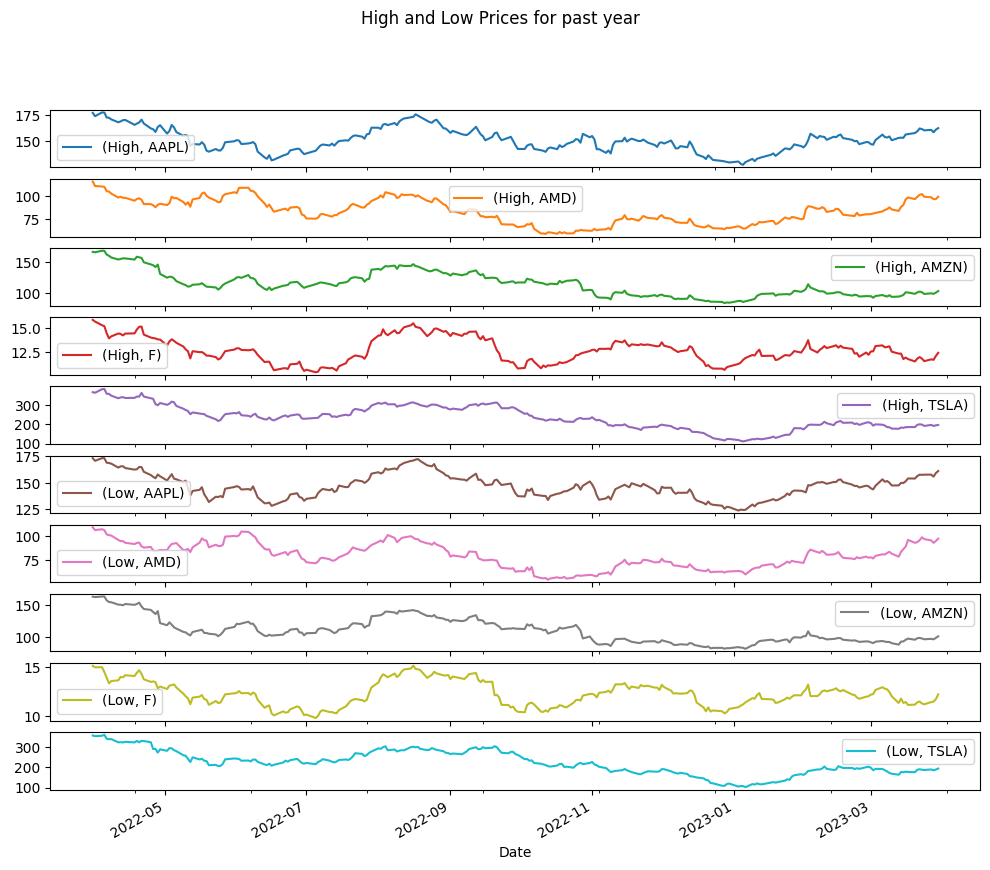

In [36]:
High_Low = ticker.loc[:, ['High', 'Low' ]]
High_Low.head()
High_Low.plot(subplots=True, figsize=(12,10), title='High and Low Prices for past year')